# Recurrent Neural Networks (Unidirectional/Bidirectional RNN)

 This worksheet explores an application of Recurrent Neural Networks (RNNs) for Named Entity Recognition (NER) (seq2seq). We will be using the familiar TensorFlow+Keras interface with emphasis on recurrent layers.



**Named Entity Recognition (NER)** is the task of identifying and categorizing key information (entities) in text. An entity can be any word or series of words that consistently refers to the same thing. We will use the [NER Corpus](https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus) dataset provided by Kaggle.
You will start by working with a unidirectional RNN and then move on to a bidirectional RNN. You will learn how to import the data, preprocess it, tokenize sentences, encode tags, build a model, train it, and evaluate its performance. The model will classify each token in the input text into a named entity tag.

## 1. Data Prepare

#### Loading the Data

We first download the data and load them into a Pandas DataFrame (ensure `kagglehub` is installed).

In [1]:
#!pip install kagglehub
import pandas as pd; import kagglehub

# Download latest version
path = kagglehub.dataset_download("naseralqaydeh/named-entity-recognition-ner-corpus")
print("Path to dataset files:", path)
ready_data = pd.read_csv(path+'/ner.csv')

Path to dataset files: /kaggle/input/named-entity-recognition-ner-corpus


In [2]:
ready_data.head(3)

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


#### Extract tags

We now look at the structure of the dataset and extract all possible tags.

In [3]:
def extract_tags(data):
  tags = {'O'}; rows = list(ready_data['Tag'])
  for row in rows:
    tags.update(eval(row))
  sorted_tags = sorted(tags - {'O'})  # Sort all except 'O'
  return ['O'] + sorted_tags
tags = extract_tags(ready_data)
print(tags)

['O', 'B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim']


#### Data Preprocessing

We and to prepare the data for modeling by tokenizing the tags (`Y`) and padding the input sequences (`X`):
- Split the data into `X` (sentences) and `Y` (tag) sequences.
- Tokenize `X`, then pad the sequences.
- Convert `Y` to a numeric form and pad with `O` tags.

We need to tokenize the sentences by mapping each word to a unique identifier, then we need to pad them because we need uniform sequence length for *batch training* (but not for applying the RNN).

Tips:
- Use `Tokenizer` from `tf.keras.preprocessing.text`.
- Use `pad_sequences` to ensure uniform length ().
- The code snippet below outlines steps, but you need to fill in the missing parts.

In [4]:
from ast import literal_eval

X = list(ready_data['Sentence']); Y = list(ready_data['Tag'])
Y_ready = []

# Convert each entry in Y from string to list object
for sen_tags in Y:
    Y_ready.append(literal_eval(sen_tags))

# Print the first sentence and its corresponding tags
print(X[1]); print(Y_ready[1])

Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


From the above example you can see that in this dataset, labels are provided for punctuations as well so for tokenization, you need to assume punctuations as individual words as well. (anything seperated by spaces is considered a word here)

##### **Tokenizie and Pad X (Sentences)**

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(lower=True, oov_token="<OOV>") ## oov is out-of-vocabulary token

# Fit the tokenizer on the sentences
tokenizer.fit_on_texts(X)

# Convert sentences to sequences
sequences_tf = tokenizer.texts_to_sequences(X)

# Pad the sequences to ensure uniform length
maxlen = max(len(sentence.split()) for sentence in X) + 1
X_preprocessed = pad_sequences(sequences_tf, maxlen=maxlen, padding='post', truncating='post')

# Print the first tokenized and padded sentence
print(X[0]); print(X_preprocessed[0])

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
[ 261    4  998   14 1839  246  453    5  546    2  122    3   61    7
  596    2  862    4  185   90   22   13   55    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


**Prepating tag encodings**
Create 2 mappings:
- tags to integer ids
- integer ids to tags

In [6]:
tags2id = {}; id2tags = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i
id2tags = {v: k for k, v in tags2id.items()}
print(tags2id); print(id2tags)

{'O': 0, 'B-art': 1, 'B-eve': 2, 'B-geo': 3, 'B-gpe': 4, 'B-nat': 5, 'B-org': 6, 'B-per': 7, 'B-tim': 8, 'I-art': 9, 'I-eve': 10, 'I-geo': 11, 'I-gpe': 12, 'I-nat': 13, 'I-org': 14, 'I-per': 15, 'I-tim': 16}
{0: 'O', 1: 'B-art', 2: 'B-eve', 3: 'B-geo', 4: 'B-gpe', 5: 'B-nat', 6: 'B-org', 7: 'B-per', 8: 'B-tim', 9: 'I-art', 10: 'I-eve', 11: 'I-geo', 12: 'I-gpe', 13: 'I-nat', 14: 'I-org', 15: 'I-per', 16: 'I-tim'}


##### **Tokenizie and Pad Y (Tags)**
Define a function to preprocess the tags similarly to the sentences:

In [7]:
import numpy as np

def preprocess_tags(tags2id, Y_ready, maxlen=105):
    Y_preprocessed = []
    max_len = 0
    for y in Y_ready:
        # Convert each tag to its ID
        tag_ids = [tags2id[t] for t in y]
        if len(tag_ids) > max_len:
            max_len = len(tag_ids)
        # Add 'O' for padding
        padded_tags = tag_ids + ([tags2id['O']] * (maxlen - len(tag_ids)))
        Y_preprocessed.append(padded_tags)
    return np.array(Y_preprocessed)

# Call preprocess_tags and store in Y_preprocessed
Y_preprocessed = preprocess_tags(tags2id, Y_ready)

Check shapes; should be `(47959, 105)`

In [8]:
print("Shape of X_preprocessed:", X_preprocessed.shape)
print("Shape of Y_preprocessed:", Y_preprocessed.shape)

Shape of X_preprocessed: (47959, 105)
Shape of Y_preprocessed: (47959, 105)


## 2. Train, Validation and Test Split
Splitting the Data into training, validation, and test set
Shuffle and split the data into training, validation, and test sets (70%/15%/15%).

In [9]:
from sklearn.model_selection import train_test_split

# Split into train and temp (validation + test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_preprocessed, Y_preprocessed, test_size=0.3, shuffle=True, random_state=555)

# Split temp into validation and test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=True, random_state=555)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 33571
Validation set size: 7194
Test set size: 7194


#### Create TensorFlow Datasets

Convert the data (NumPy arrays) into TensorFlow batches using the function `tf.data.Dataset.from_tensor_slices()`

In [10]:
import tensorflow as tf

BATCH_SIZE = 132

# Add code here: create train_dataset, val_dataset, test_dataset using tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)


## 3. Unidirectional RNN

Goal:

- Build a model using a unidirectional LSTM.
- Compare performance with a bidirectional version later.

Instructions:

- Create an Embedding layer.
- Add one or two LSTM layers (unidirectional). you can use `tanh` for activation
- Use `TimeDistributed(Dense(num_tags, activation='softmax'))` for prediction.

Tips:

- `num_tags = len(tags)` (here is 17); `max_words = len(tokenizer.word_index)+1` (here is 27955)
- When using a unidirectional LSTM, simply add `tf.keras.layers.LSTM(...)` layers.
- After confirming the unidirectional model works, you will later switch to a bidirectional model.


### 3.1. Build Model (undirectional RNN)

In [11]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout

embedding_dim = 300
num_tags = len(tags)
maxlen = 105
max_words = len(tokenizer.word_index)+1

# Build a Sequential model with:
# 1) Embedding layer (input_dim=max_words, output_dim=embedding_dim, input_length=maxlen)
# 2) One or two LSTM layers (return_sequences=True)
# 3) TimeDistributed(Dense(num_tags, activation='softmax'))

model = tf.keras.models.Sequential([
    Embedding(max_words, embedding_dim, input_length=maxlen),
    LSTM(units=100, activation='tanh', return_sequences=True),
    Dropout(0.5),
    LSTM(units=100, activation='tanh', return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 3.2. Train Model (Unidirectional RNN)

Train the model and monitor training/validation accuracy.


In [12]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.9451 - loss: 0.3802 - val_accuracy: 0.9686 - val_loss: 0.1317
Epoch 2/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.9684 - loss: 0.1307 - val_accuracy: 0.9698 - val_loss: 0.1115
Epoch 3/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9697 - loss: 0.1116 - val_accuracy: 0.9729 - val_loss: 0.0950


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 105, 300)            │       8,386,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 105, 100)            │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 105, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 105, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 105, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 105, 17)             │           1,717 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,887,053 (98.75 MB)

 Trainable params: 8,629,017 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,258,036 (65.83 MB)

### 3.3. Evaluation (undirectional RNN)

Plot accuracy and loss curves for the training and validation sets, and evaluate the trained model on the test dataset.


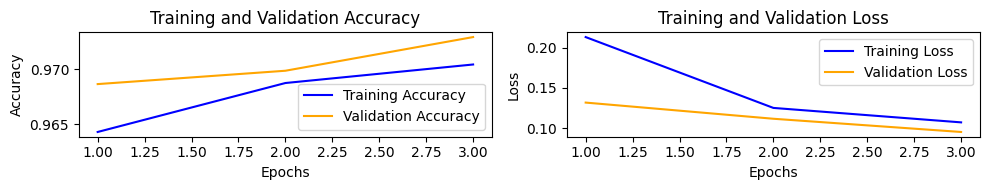

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10, 2))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy');plt.xlabel('Epochs');plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss');plt.xlabel('Epochs');plt.ylabel('Loss')
plt.legend()

plt.tight_layout();plt.show()


In [15]:
# Testset Evaluation
model.evaluate(test_dataset)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9718 - loss: 0.0983


[0.09776290506124496, 0.9719874262809753]

### 3.4. Inference Function (predictions on single example)

We will now create a function to make predictions on a single example and map IDs back to words and tags.
We will test the function on a random test example.


In [16]:
word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}

def make_prediction(model, preprocessed_sentence, id2word, id2tags):
    # Ensure the input is of shape (1, maxlen)
    preprocessed_sentence = preprocessed_sentence.reshape((1, preprocessed_sentence.shape[0]))

    # Convert back to text
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = [id2word[w] for w in sentence]
    original_sententce = ' '.join(word_list)

    # Add code here: run model prediction
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)

    pred_tags = [id2tags[p] for p in prediction]
    return original_sententce, pred_tags


In [17]:
# Test the prediction function on a random test example
example_sentence = X_test[500]
original_sententce, pred_tags = make_prediction(model, example_sentence, id2word, id2tags)
print("Sentence: \n",original_sententce);print("Predicted tags: \n",pred_tags)

# Compare with Actual Tags
actual_tags = [id2tags[p] for p in Y_test[500]]
print("Actual tags: \n:", actual_tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sentence: 
 with the advent of the cold war two german states were formed in 1949 the western federal republic of germany frg and the eastern german democratic republic gdr
Predicted tags: 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual tags: 
: ['O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'B-gpe', 'B-geo', 'I-geo', 'O', 'O', 'O', 'O', 'O', 'O', '

These are not good predictions even though the model showed 95%+ accuracy.
This is because the data has a lot of O tags and predicting O artificially inflates the accuracy as most of the predictions will be correct for O.


## 4. Bidirectional RNN

Now that you have a working unidirectional model, modify it to use a **Bidirectional** LSTM layer.
- Rebuild the model by replacing the LSTM layers with `tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(...))`.
- Retrain on 4 epochs and compare performance.
- Compare the results (accuracy, loss) with the unidirectional model.


### 4.1. Build Model (Bidirectional RNN)

In [18]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.layers import Bidirectional


embedding_dim = 300; num_tags = len(tags); maxlen = 105
max_words = len(tokenizer.word_index)+1

# Build a new model using Bidirectional LSTM layers
model_bi = tf.keras.models.Sequential([
    Embedding(max_words, embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

model_bi.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
model_bi.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 4.2.Train Model (Bidirectional RNN)

In [19]:
# Train model_bi on train_dataset and val_dataset
history_bi = model_bi.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.9450 - loss: 0.2919 - val_accuracy: 0.9702 - val_loss: 0.1090
Epoch 2/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.9706 - loss: 0.1049 - val_accuracy: 0.9762 - val_loss: 0.0771
Epoch 3/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9759 - loss: 0.0770 - val_accuracy: 0.9787 - val_loss: 0.0690


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 105, 300)            │       8,386,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 105, 100)            │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 105, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 105, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 105, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 105, 17)             │           1,717 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,887,053 (98.75 MB)

 Trainable params: 8,629,017 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,258,036 (65.83 MB)

### 4.3. Evaluation (Bidirectional RNN)
Plot accuracy and loss curves for the training and validation sets, and evaluate the trained model on the test dataset.

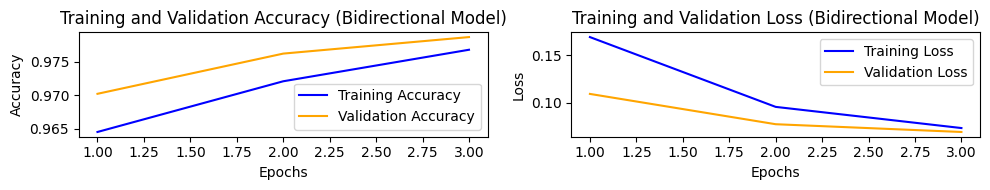

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_bi.history['accuracy']) + 1)

plt.figure(figsize=(10, 2))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history_bi.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs, history_bi.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy (Bidirectional Model)'); plt.xlabel('Epochs')
plt.ylabel('Accuracy'); plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_bi.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, history_bi.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss (Bidirectional Model)');plt.xlabel('Epochs')
plt.ylabel('Loss');plt.legend()

plt.tight_layout();plt.show()

In [22]:
# Evaluate model_bi on test_dataset
model_bi.evaluate(test_dataset)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9778 - loss: 0.0715


[0.07133910059928894, 0.9780186414718628]

### 4.4. Predictions on single example (inference)

We will now create a function to make predictions on a single example and map IDs back to words and tags.
We will test the function on a random test example.


In [23]:
# Test the prediction function on a random test example
example_sentence = X_test[500]
original_sententce, pred_tags = make_prediction(model_bi, example_sentence, id2word, id2tags)
print("Sentence: \n",original_sententce);print("Predicted tags: \n",pred_tags)

# Compare with Actual Tags
actual_tags = [id2tags[p] for p in Y_test[500]];print("Actual tags: \n:", actual_tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sentence: 
 with the advent of the cold war two german states were formed in 1949 the western federal republic of germany frg and the eastern german democratic republic gdr
Predicted tags: 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'B-gpe', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual tags: 
: ['O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'B-gpe', 'B-geo', 'I-geo', 'O', 'O', 'O', 'O', 'O'